In [2]:
import tensorflow as tf

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

CLASS_NAMES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [3]:
def read_and_decode(filename, resize_dims):
  # 1: Read the raw file
  img_bytes = tf.io.read_file(filename)

  # 2: Decode image Data
  img = tf.image.decode_jpeg(img_bytes, channels=IMG_CHANNELS)

  # 3: Convert pixel values to floats in [0, 1]
  img = tf.image.convert_image_dtype(img, tf.float32)

  # 4: Resize the image to match desired dimensions
  img = tf.image.resize(img, resize_dims)

  return img

def parse_csvline(csv_line):
  # record_defaults specify the data types for each column
  record_default = ['', '']
  filename, label_string = tf.io.decode_csv(csv_line, record_default)

  # Load the image
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])

  # Convert label string to integer based on the CLASS_NAMES
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

In [4]:
train_dataset = (
    tf.data.TextLineDataset('gs://cloud-ml-data/img/flower_photos/train_set.csv')
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(16)
)

eval_dataset = (
    tf.data.TextLineDataset('gs://cloud-ml-data/img/flower_photos/eval_set.csv')
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(16)
)


In [5]:
for image_batch, label_batch in train_dataset.take(1):
  print('Image batch shape: ', image_batch.shape)
  print('Label batch shape: ', label_batch.shape)
  print('Labels:', label_batch.numpy())

Image batch shape:  (16, 224, 224, 3)
Label batch shape:  (16,)
Labels: [0 1 1 1 0 2 1 0 4 3 0 3 1 4 4 1]


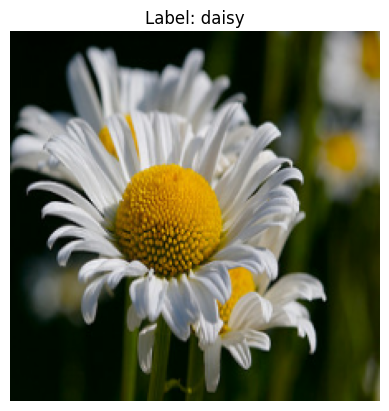

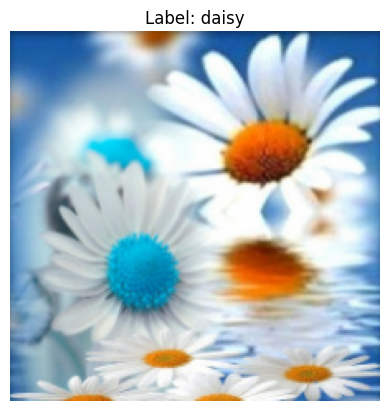

In [6]:
# Visualize a single image
import matplotlib.pyplot as plt

for image_batch, label_batch in train_dataset.take(2):
  # Take the first image fromt he batch
  first_image = image_batch[0]
  first_label = label_batch[0]

  # Convert tensor to numpy array
  plt.imshow(first_image.numpy())
  plt.title(f'Label: {CLASS_NAMES[first_label]}')
  plt.axis('off')
  plt.show()

In [7]:
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
    keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
EPOCHS = 5

history = model.fit(
    train_dataset,
    validation_data = eval_dataset,
    epochs=EPOCHS
)

Epoch 1/5
    207/Unknown 210s 1s/step - accuracy: 0.3067 - loss: 18.3441

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


207/207 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.3068 - loss: 18.3195 - val_accuracy: 0.2973 - val_loss: 14.4315
Epoch 2/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 194s 805ms/step - accuracy: 0.4225 - loss: 9.0265 - val_accuracy: 0.2892 - val_loss: 20.8730
Epoch 3/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 199s 791ms/step - accuracy: 0.4413 - loss: 11.4397 - val_accuracy: 0.3351 - val_loss: 16.5300
Epoch 4/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 140s 678ms/step - accuracy: 0.4492 - loss: 13.1354 - val_accuracy: 0.3784 - val_loss: 18.3498
Epoch 5/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 141s 673ms/step - accuracy: 0.4879 - loss: 11.0916 - val_accuracy: 0.4081 - val_loss: 9.9404


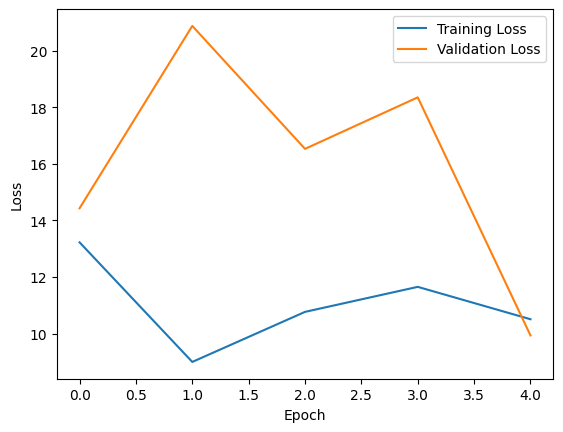

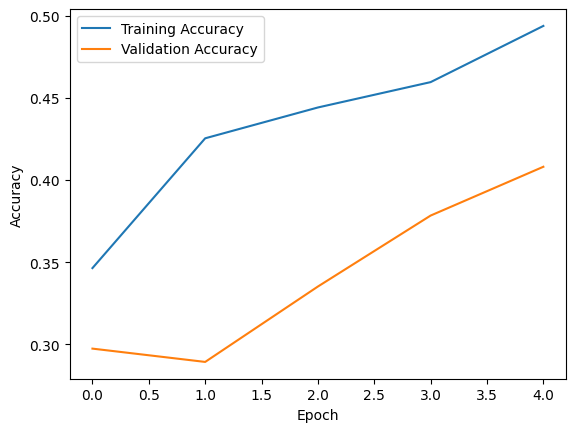

In [11]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


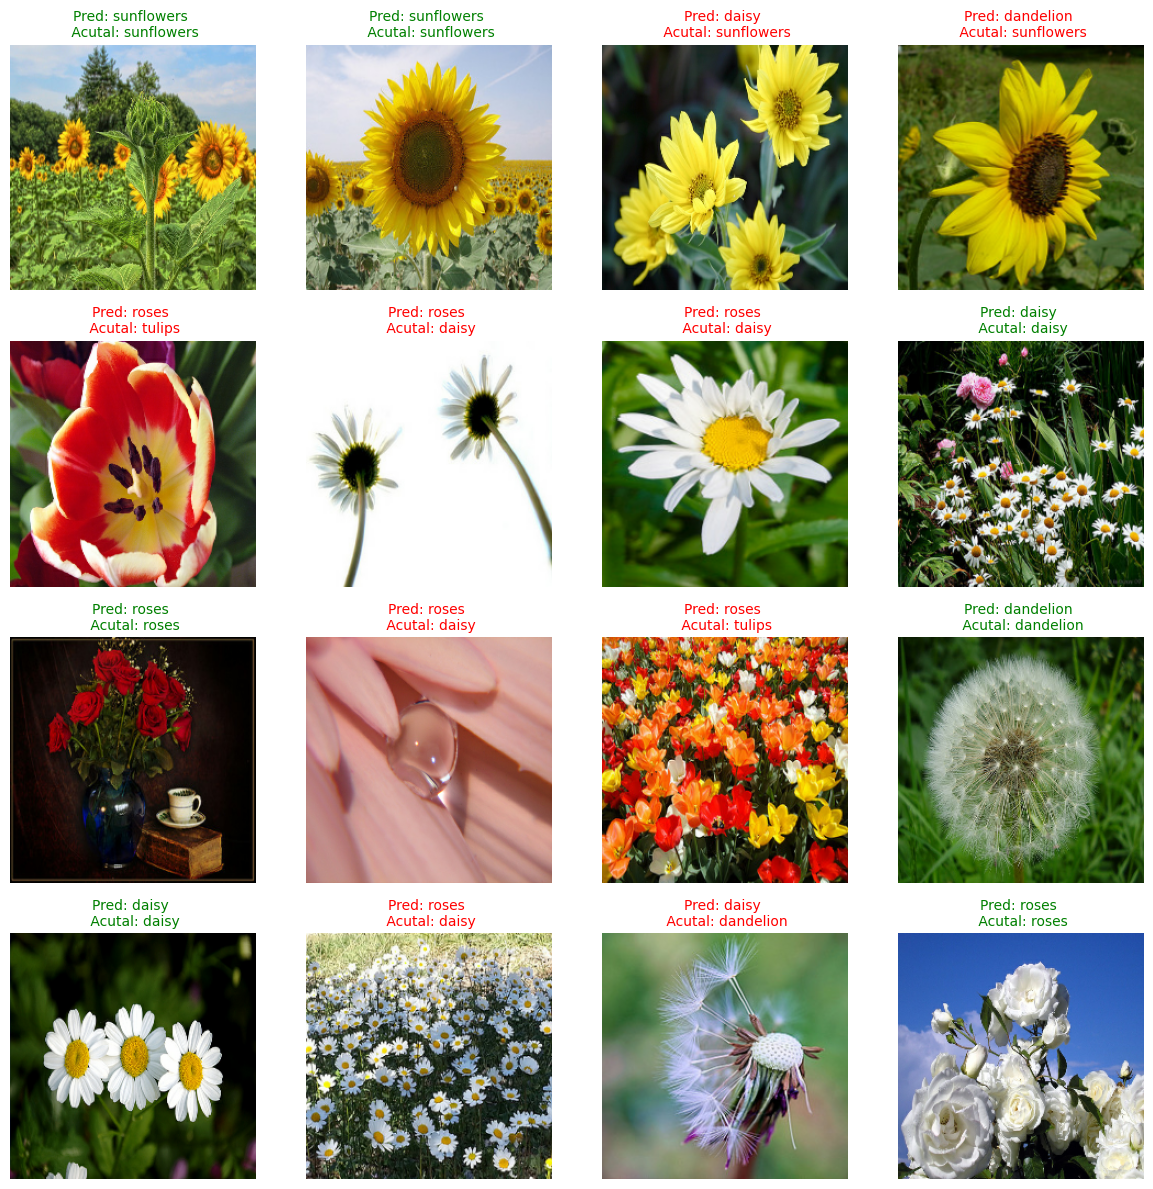

In [14]:
import numpy as np
import math

# Take exactlty one batch from the evaluation dataset (16 images)
for images, labels in eval_dataset.take(1):
  # Gen model predictions for this batch
  batch_predictions = model.predict(images)
  predicted_indices = np.argmax(batch_predictions, axis=1)

  # Number of images in this batch
  num_images = images.shape[0]

  # Confiter how many images to display per row
  num_cols = 4
  num_rows = math.ceil(num_images /num_cols)

  # Create a figure with a suitable size
  plt.figure(figsize=(12, 3 * num_rows))

  for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)

    # Display the image
    plt.imshow(images[i].numpy())
    plt.axis('off')

    # Get predicted and actual class names
    pred_class = CLASS_NAMES[predicted_indices[i]]
    actual_class = CLASS_NAMES[labels[i].numpy()]

    # Show both predicted and actual labels as title
    plt.title(f'Pred: {pred_class} \n Acutal: {actual_class}', fontsize=10, color='g' if pred_class == actual_class else 'r')

# Adjust spacing to avoid overlapping title, etc.
plt.tight_layout()
plt.show()